In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
from pandas import (
    read_sql_query, 
    DataFrame,
    ExcelWriter,
    options
)
from dataframe_image import export


from enum import Enum
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
class Period(Enum):
    date = '2022-01-01'
    wb=''
    date_du_jour = datetime.today().strftime("%d_%m_%Y")

In [15]:
load_dotenv()
# get the environment variables needed
USER = config('USRCaris')
PASSWORD = config('PASSCaris')
HOSTNAME = config('HOSTCaris')
DBNAME = config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(
    f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")

query_presenceQty = f'''
SELECT 
    a.*, COUNT(*) AS qte_pres_by_creator
FROM
    (SELECT 
            dgs.created_by,
            au.email AS email,
            au.username
    FROM
        caris_db.dream_group_session dgs
    LEFT JOIN dream_group_attendance dga ON dgs.id = dga.id_group_session
    LEFT JOIN dream_group dg ON dgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dgs.created_by
    WHERE
        dga.value = 'P'
            AND dgs.date >= '{Period.date.value}') a
GROUP BY a.created_by
'''

query_beneficiariesQty = f'''
SELECT *, COUNT(*) AS qte_by_creator FROM
    (SELECT
        dgs.id AS id_session,
            topic,
            date,
            dga.id_patient AS id_patient,
            dgs.created_by,
            lc.name AS commune,
            ld.name AS departement,
            dh.name AS hub,
            au.email AS email,
            au.username,
            b.first_name,
            b.last_name,
            p.patient_code as dreams_code
    FROM
        caris_db.dream_group_session dgs
    INNER JOIN dream_group_attendance dga ON dgs.id = dga.id_group_session
        LEFT JOIN dream_group dg ON dgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dgs.created_by
    left join beneficiary b on dga.id_patient=b.id_patient
    left join patient p on p.id=dga.id_patient
    WHERE
        dga.value = 'P'
            AND dgs.date >= '{Period.date.value}') a
            group by a.id_patient, a.username
'''

query_parentingBene = f'''
SELECT 
    *, COUNT(*) AS qte_by_creator
FROM
    (SELECT 
        dpgs.id_group AS id_session,
            topic,
            date,
            dpga.id_patient AS id_patient,
            dpgs.created_by,
            lc.name AS commune,
            ld.name AS departement,
            dh.name AS hub,
            au.email AS email,
            au.username,
            b.first_name,
            b.last_name,
            p.patient_code AS dreams_code
    FROM
        caris_db.dream_parenting_group_session dpgs
    LEFT JOIN dream_parenting_group_attendance dpga ON dpgs.id = dpga.id_parenting_group_session
    LEFT JOIN dream_group dg ON dpgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dpgs.created_by
    LEFT JOIN beneficiary b ON dpga.id_patient = b.id_patient
    LEFT JOIN patient p ON p.id = dpga.id_patient
    WHERE
        ((dpga.parent_g = 'P')
            OR (dpga.parent_vd = 'P')
            OR (dpga.yg_g = 'P')
            OR (dpga.yg_vd = 'P'))
            AND (dpgs.date >= '{Period.date.value}')) a
GROUP BY a.id_patient , a.username
'''

query_parentingQty = f'''
SELECT 
    a.*, COUNT(*) AS qte_by_creator
FROM
    (SELECT 
        dpgs.created_by, au.email AS email, au.username
    FROM
        caris_db.dream_parenting_group_session dpgs
    LEFT JOIN dream_parenting_group_attendance dpga ON dpgs.id = dpga.id_parenting_group_session
    LEFT JOIN dream_group dg ON dpgs.id_group = dg.id
    LEFT JOIN dream_hub dh ON dg.id_dream_hub = dh.id
    LEFT JOIN lookup_commune lc ON lc.id = dh.commune
    LEFT JOIN lookup_departement ld ON ld.id = lc.departement
    LEFT JOIN auth_users au ON au.id = dpgs.created_by
    WHERE ((dpga.parent_g = 'P') OR (dpga.parent_vd= 'P') OR (dpga.yg_g='P') OR (dpga.yg_vd='P') )
            AND (dpgs.date >= '{Period.date.value}') ) a
GROUP BY a.created_by
'''




pres_byAgent= read_sql_query(query_presenceQty, engine, parse_dates=True)
ben_byAgent = read_sql_query(query_beneficiariesQty, engine, parse_dates=True)

pres_parenting= read_sql_query(query_parentingQty, engine, parse_dates=True)
parenting_byAgent = read_sql_query(query_parentingBene, engine, parse_dates=True)


# close the pool of connection
engine.dispose()


True

In [16]:
pres_byAgent.rename(columns={'qte_pres_by_creator':'nombre_pres'},inplace=True)
ben_byAgent.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)
pres_parenting.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)
parenting_byAgent.rename(columns={'qte_by_creator':'nombre_pres'},inplace=True)

In [17]:
print('Nombre de presence totale: ',pres_byAgent.nombre_pres.sum())
print('Nombre de presence totale: ',ben_byAgent.nombre_pres.sum())
print('Nombre de filles: ',ben_byAgent.id_patient.count())
print('Nombre de presence totale parenting: ',pres_parenting.nombre_pres.sum())
print('Nombre de presence totale parenting: ',parenting_byAgent.nombre_pres.sum())
print('Nombre de filles: ',parenting_byAgent.id_patient.count())

Nombre de presence totale:  27831
Nombre de presence totale:  27831
Nombre de filles:  1620
Nombre de presence totale parenting:  180
Nombre de presence totale parenting:  180
Nombre de filles:  26


# First Component

In [30]:
pres_byAgent = pres_byAgent[['username','email','nombre_pres']]
pres_byAgent.fillna("noID",inplace=True)
pres_byAgent.style.highlight_max(subset=['nombre_pres'])

print('---------------------------------------------------------------------------------------------')

pres_parenting = pres_parenting[['username','email','nombre_pres']]
pres_parenting.style.highlight_max(subset=['nombre_pres'])


#ordered_pres_byAgent = pres_byAgent.nombre_pres.sort_values().to_list()
#ordered_pres_parenting = pres_parenting.nombre_pres.sort_values().to_list()

,username,email,nombre_pres
0,noID,noID,1801
1,fbyron,byronfabrice9@gmail.com,2586
2,billyjolicoeur,billyjolicoeur95@gmail.com,11896
3,FredlyEliona,elionafredly7@gmail.com,2813
4,dchelot,blonnichel@yahoo.fr,4534
5,pggd1234,gerald.poteau@carisfoundationintl.org,825
6,France14,francenelstjean.saed@yahoo.com,3046
7,BonWoodRidchard,twoody103@gmail.com,330


---------------------------------------------------------------------------------------------


,username,email,nombre_pres
0,fbyron,byronfabrice9@gmail.com,180


# Graphe Component I

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Nombre de presence Currriculum par agents depuis le 2022-01-01')

Text(11896.25, 0.0, '11896')

Text(4534.25, 1.0, '4534')

Text(3046.25, 2.0, '3046')

Text(2813.25, 3.0, '2813')

Text(2586.25, 4.0, '2586')

Text(1801.25, 5.0, '1801')

Text(825.25, 6.0, '825')

Text(330.25, 7.0, '330')

Text(-80, -20, 'source: HIVHaiti')

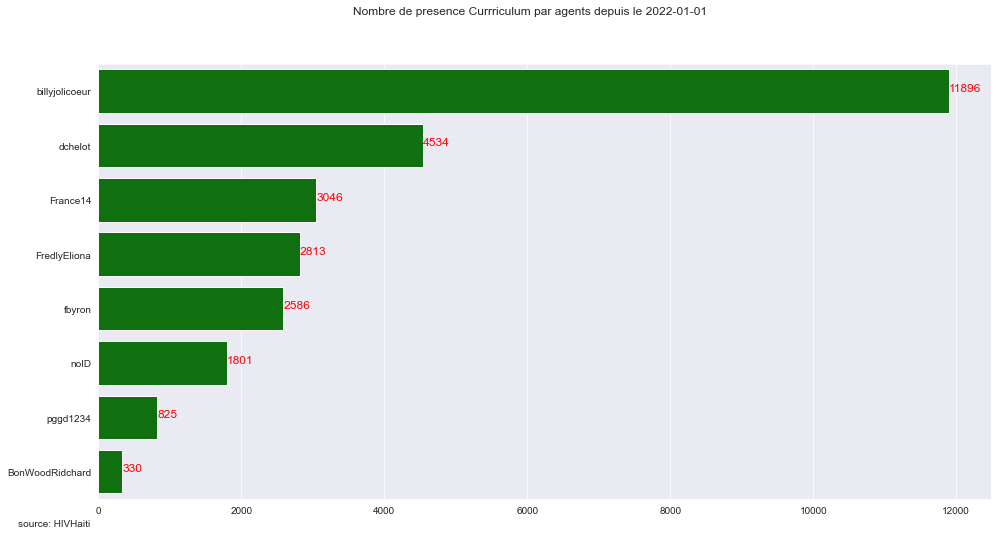

In [31]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nombre_pres",y="username",data=pres_byAgent,color="Green",order=pres_byAgent.sort_values("nombre_pres",ascending=False).username,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de presence Currriculum par agents depuis le {Period.date.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )
    plt.savefig(f"saisie_curriculum",dpi=1000)
except ValueError:
    print(f"no activities where registered")

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'Nombre de presence parenting par agents depuis le 2022-01-01')

Text(180.25, 0.0, '180')

Text(-80, -20, 'source: HIVHaiti')

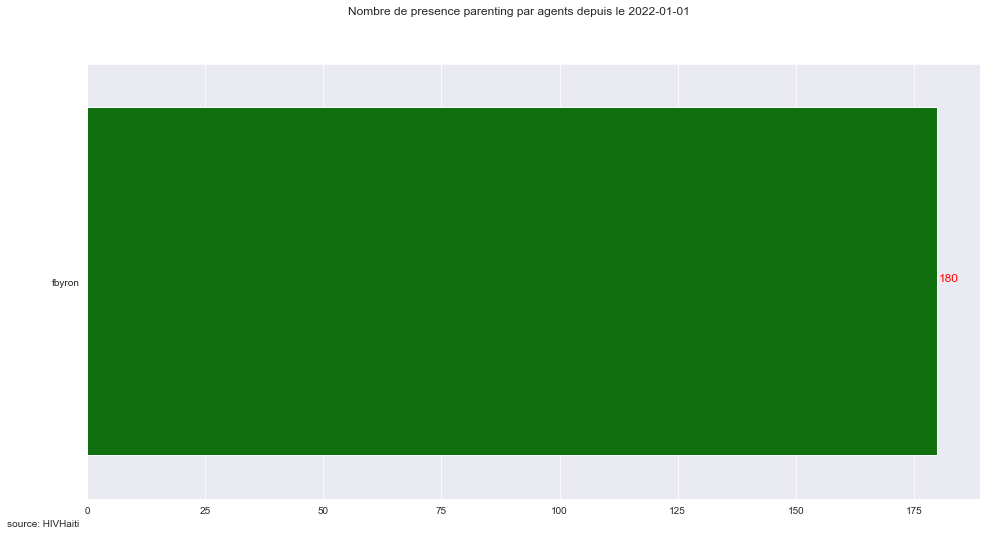

In [32]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nombre_pres",y="username",data=pres_parenting,color="Green",order=pres_parenting.sort_values("nombre_pres",ascending=False).username,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de presence parenting par agents depuis le {Period.date.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))
    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )
    plt.savefig(f"saisie_parenting",dpi=1000)
except ValueError:
    print(f"no activities where registered")

# Validation of the pivot table

In [33]:
def validation_pivot(pt):
    if not pt.empty:
        pt = pt.pivot_table(values='id_patient',index='username',columns='commune',aggfunc='count',fill_value=0,margins=True, margins_name='Total')
    if pt.empty:
        pt =  DataFrame({"resultats":["No data entry"]})
    return pt

# Component 2

In [34]:
options.display.latex.repr = True

#ben_table = ben_byAgent.pivot_table(values='id_patient',index='username',columns='commune',aggfunc='count',fill_value=0,margins=True, margins_name='Total')
ben_table = validation_pivot(ben_byAgent)
ben_table = ben_table.style.highlight_max()
ben_table

print('-----------------------------------------------------------------------------------------------------')

#parenting_table = parenting_byAgent.pivot_table(values='id_patient',index='username',columns='commune',aggfunc='count',fill_value=0,margins=True, margins_name='Total')
parenting_table = validation_pivot(parenting_byAgent)
parenting_table = parenting_table.style.highlight_max()
parenting_table

export(ben_table,'ben_table.png')
export(parenting_table,'parenting_table.png')

commune,Delmas,Desdunes,Dessalines,Grande Saline,Kenscoff,Montrouis,Petite Rivière de l'Artibonite,Port-au-Prince,Pétionville,Saint-Marc,Tabarre,Verrettes,Total
username,,,,,,,,,,,,,
BonWoodRidchard,0,0,0,0,9,0,0,8,0,0,0,0,17
France14,0,0,221,0,0,0,0,0,0,0,0,0,221
FredlyEliona,23,21,0,0,77,0,0,0,14,0,0,0,135
billyjolicoeur,0,0,0,14,500,0,9,6,39,0,16,0,584
dchelot,0,0,0,0,0,0,0,0,0,218,0,48,266
fbyron,4,2,0,116,28,0,6,16,0,0,65,0,237
pggd1234,0,0,0,0,0,17,0,0,0,18,0,20,55
Total,27,23,221,130,614,17,15,30,53,236,81,68,1515


-----------------------------------------------------------------------------------------------------


commune,Kenscoff,Total
username,,
fbyron,26,26
Total,26,26


/usr/local/lib/python3.10/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0308/105450.926221:INFO:headless_shell.cc(659)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmpk17er5oi/temp.png.
[0308/105454.075099:INFO:headless_shell.cc(659)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmp7b1eexhs/temp.png.


# 3 component 

In [35]:
options.display.latex.repr = True

curriculum_result = DataFrame(
    [
        {'Nombre de fille': ben_byAgent.id_patient.count(),
        'Nombre de presence': pres_byAgent.nombre_pres.sum()}
    ]
)
curriculum_result.style.highlight_max()

print('-----------------------------------------------------------------------')

parenting_result = DataFrame(
    [
        {'Nombre de fille/parent parenting': parenting_byAgent.id_patient.count(),
        'Nombre de presence': pres_parenting.nombre_pres.sum()}
    ]
)
parenting_result.style.highlight_max()

export(curriculum_result,'curriculum_result.png')
export(parenting_result,'parenting_result.png')

,Nombre de fille,Nombre de presence
0,1620,27831


-----------------------------------------------------------------------


,Nombre de fille/parent parenting,Nombre de presence
0,26,180


[0308/105456.416358:INFO:headless_shell.cc(659)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmpdujxn5ts/temp.png.
[0308/105458.501999:INFO:headless_shell.cc(659)] Written to file /var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/tmp461v385b/temp.png.


# Report

In [36]:
all_report = ExcelWriter(f"rapport_performance.xlsx",engine="openpyxl")
curriculum_result.to_excel(all_report,sheet_name="resultat_curriculum",index=False,na_rep="")
pres_byAgent.to_excel(all_report,sheet_name="presence_agent_curriculum",index=False,na_rep="")
ben_table.to_excel(all_report,sheet_name="ben_communes_curriculum",index=True,na_rep="")
parenting_result.to_excel(all_report,sheet_name="resultat_parenting",index=False,na_rep="")
pres_parenting.to_excel(all_report,sheet_name="pres_agent_parenting",index=False,na_rep="")
parenting_table.to_excel(all_report,sheet_name="ben_communes_parenting",index=True,na_rep="")
all_report.save() 